In [3]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import random
import ast
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# 使用内置样式
plt.style.use('ggplot')

# 使用seaborn颜色主题
sns.set_palette("deep")

# 修改字体和字号
matplotlib.rcParams['font.size'] = 12

In [13]:
preliminary_A_url = f"./com/A_preliminary.csv" 
Curl = f"./com/C_final.csv"
track2_face_attrs_url = r"./com/track2_face_attrs.txt"
item_related_data_url = r"./com/item_related_data.csv"

### 数据读取

#### preliminary

In [14]:
a_preliminary_data_processed = pd.read_csv(preliminary_A_url).iloc[:,2:]
c_preliminary_data_processed = pd.read_csv(Curl).iloc[:,2:].fillna(-1)
a_preliminary_data_processed.to_csv("./new_data/a_preliminary_data_processed.csv")
c_preliminary_data_processed.to_csv("./new_data/c_preliminary_data_processed.csv")

#### item_related_data_df 

In [4]:
item_related_data_df = pd.read_csv(item_related_data_url,index_col=0)
item_related_data_df.to_csv("./new_data/item_related_data_df.csv")
item_related_data_df.head()

,item_id,video_duration,author_id,item_city,music_id
0,46822,0.000229,231026,2,5330
1,1209078,0.000057,456220,3,39979
2,1209079,0.000129,456221,4,0
3,1209081,0.000143,122067,6,3639
4,269351,0.000057,6757,7,0


### 数据预处理

In [108]:
item_related_data_df = pd.read_csv("./new_data/item_related_data_df.csv").iloc[:,1:]
a_preliminary_data_processed = pd.read_csv("./new_data/a_preliminary_data_processed.csv").iloc[:,1:]
c_preliminary_data_processed = pd.read_csv("./new_data/c_preliminary_data_processed.csv").iloc[:,1:]

In [7]:
def process_dataframe(df, preliminary_data_df):
    # df传进来去重
    df = df.drop_duplicates(subset='item_id', keep='first')
    
    # 将 df 和 preliminary_data_df 依据 item_id 列合并
    merged_df = preliminary_data_df.merge(df, on='item_id', how='left')
    
    # 删除缺失值
    filled_df = merged_df.fillna(-1)

    # 选择保留 df 的列
    final_df = filled_df[df.columns]

    return final_df

#### item_related_data

In [8]:
item_related_data_matrix = process_dataframe(item_related_data_df,a_preliminary_data_processed).drop('item_id', axis=1).values
c_item_related_data_matrix = process_dataframe(item_related_data_df,c_preliminary_data_processed).drop('item_id', axis=1).values
np.save('./new_data/item_related_array2.npy', item_related_data_matrix)
np.save('./new_data/c_item_related_array2.npy', c_item_related_data_matrix)

### 划分测试集与训练集

In [83]:
a_preliminary_data_processed = pd.read_csv("./new_data/a_preliminary_data_processed.csv").iloc[:,1:]
a_preliminary_feats = a_preliminary_data_processed.drop(['item_id','user_id','label','create_time'],axis=1)

In [84]:
# 读取numpy数组
item_related_array = np.load('./new_data/item_related_array2.npy')
face_attrs_array = np.load('./new_data/face_attrs_array.npy')

In [85]:
# 获取各个模态的训练和验证数据
item_related_dim = item_related_array.shape[1]
face_attrs_dim = face_attrs_array.shape[1]
a_preliminary_dim = a_preliminary_feats.shape[1]

In [86]:
# 水平合并特征
X = np.hstack((
    a_preliminary_feats.values,  # 将DataFrame转换为numpy数组
    item_related_array
))
y = a_preliminary_data_processed['label'].values

In [87]:
# 将数据划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 对训练数据应用下采样
class_ratio = {0: int(sum(y_train == 1) * 7), 1: sum(y_train == 1)}

rus = RandomUnderSampler(sampling_strategy=class_ratio, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# 减少样本数量，降低时间成本
X_test, _, y_test, _ = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42)

# 提取a_preliminary和item_related特征
a_preliminary_train = X_train_resampled[:, :a_preliminary_dim]
a_preliminary_test = X_test[:, :a_preliminary_dim]

item_related_train = X_train_resampled[:, a_preliminary_dim:]
item_related_test = X_test[:, a_preliminary_dim:]


<AxesSubplot:ylabel='None'>

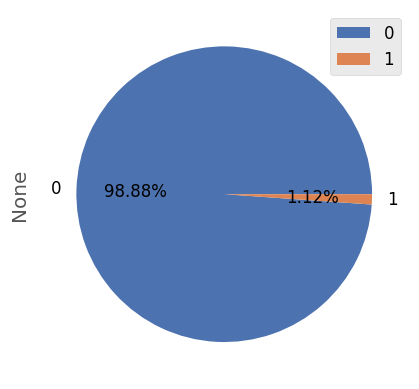

In [88]:
pd.Series(y.tolist()).value_counts().plot.pie(legend=[0,1],autopct='%.2f%%')

<AxesSubplot:ylabel='None'>

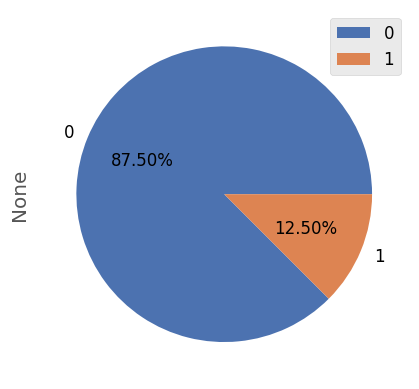

In [89]:
pd.Series(y_train_resampled.tolist()).value_counts().plot.pie(legend=[0,1],autopct='%.2f%%')

In [90]:
# 保存训练数据
np.save('./new_data/item_related_train.npy', item_related_train)
np.save('./new_data/a_preliminary_train.npy', a_preliminary_train)
np.save('./new_data/y_train_resampled.npy', y_train_resampled)

# 保存验证数据
np.save('./new_data/item_related_test.npy', item_related_test)
np.save('./new_data/a_preliminary_test.npy', a_preliminary_test)
np.save('./new_data/y_test.npy', y_test)

### 训练

In [4]:
# 加载数据
item_related_train = np.load('./new_data/item_related_train.npy')
a_preliminary_train = np.load('./new_data/a_preliminary_train.npy')
y_train_resampled = np.load('./new_data/y_train_resampled.npy')

item_related_test = np.load('./new_data/item_related_test.npy')
a_preliminary_test = np.load('./new_data/a_preliminary_test.npy')
y_test = np.load('./new_data/y_test.npy')

item_related_val = np.load('./new_data/c_item_related_array2.npy')
c_preliminary_data_processed = pd.read_csv("./new_data/c_preliminary_data_processed.csv").iloc[:,1:]
c_preliminary_feats = c_preliminary_data_processed.drop(['item_id','user_id','create_time'], axis=1)

In [8]:
# 定义基础模型
base_models = [
    RandomForestClassifier(
        n_estimators=2000,
        max_depth=50,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features='auto',
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ),
    XGBClassifier(
        n_estimators=50,
        max_depth=5,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_lambda=2,
        reg_alpha=0.5,
        min_child_weight=5,
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42
    ),
    LGBMClassifier(
        n_estimators=500,
        learning_rate=0.1,
        num_leaves=31,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1,
        reg_alpha=0,
        min_child_weight=1,
        random_state=42,
        n_jobs=-1
    )
]

# 定义元模型
meta_model = LogisticRegression(random_state=42)

# 定义k折交叉验证
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 准备保存基础模型的预测结果
train_meta = np.zeros((y_train_resampled.shape[0], len(base_models)))
test_meta = np.zeros((y_test.shape[0], len(base_models)))

# 定义k折交叉验证
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 准备保存基础模型的预测结果
train_meta = np.zeros((y_train_resampled.shape[0], len(base_models)))
test_meta = np.zeros((y_test.shape[0], len(base_models)))

In [9]:
# 为每个模态特征创建一个模型列表
modalities = [
    item_related_train,
    a_preliminary_train
]

modalities_test = [
    item_related_test,
    a_preliminary_test
]

modalities_val = [
    item_related_val,
    c_preliminary_feats.values,
]

In [11]:
base_model_auc = []

for idx, model in tqdm(enumerate(base_models)):
    model_auc = [] 
    for i, (train_modality, test_modality) in enumerate(zip(modalities, modalities_test)):
        cv_auc = []
        for train_idx, test_idx in kf.split(train_modality, y_train_resampled):
            model.fit(train_modality[train_idx], y_train_resampled[train_idx])
            train_meta[test_idx, idx] += model.predict_proba(train_modality[test_idx])[:, 1] / len(modalities)
            cv_auc.append(roc_auc_score(y_train_resampled[test_idx], model.predict_proba(train_modality[test_idx])[:, 1]))
        model_auc.append(np.mean(cv_auc))
        
        model.fit(train_modality, y_train_resampled)
        test_meta[:, idx] += model.predict_proba(test_modality)[:, 1] / len(modalities)
    
    base_model_auc.append(np.mean(model_auc)) 

# 计算基础模型的权重
base_model_weights = np.array([x - 0.5 for x in base_model_auc]) / np.sum([x - 0.5 for x in base_model_auc])

# 使用权重调整训练元数据和测试元数据
train_meta_weighted = train_meta * base_model_weights.reshape(1, -1)
test_meta_weighted = test_meta * base_model_weights.reshape(1, -1)

meta_model.fit(train_meta_weighted, y_train_resampled)  # 使用调整后的训练元数据训练元模型

test_pred_weighted = meta_model.predict_proba(test_meta_weighted)[:, 1]  # 使用调整后的测试元数据进行预测

# 计算加权AUC
weighted_auc = roc_auc_score(y_test, test_pred_weighted)
print(f"Weighted AUC = {weighted_auc}")


3it [10:39, 213.25s/it]


Weighted AUC = 0.9098323469829397


In [12]:
# 计算基础模型在验证集上的预测结果
val_meta = np.zeros((c_preliminary_feats.shape[0], len(base_models)))

for idx, model in enumerate(base_models):
    for i, (train_modality, val_modality) in enumerate(zip(modalities, modalities_val)):
        # 在整个训练集上训练基础模型
        model.fit(train_modality, y_train_resampled)
        
        # 获取基础模型在验证集上的预测结果
        val_meta[:, idx] += model.predict_proba(val_modality)[:, 1] / len(modalities)

# 使用基础模型的预测结果训练元模型
meta_model.fit(train_meta, y_train_resampled)

# 使用元模型对验证集进行预测
val_pred = meta_model.predict_proba(val_meta)[:, 1]

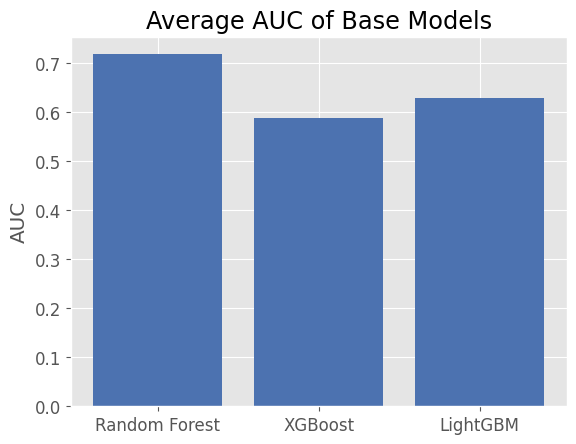

In [13]:
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plt.bar(model_names, base_model_auc)
plt.ylabel('AUC')
plt.title('Average AUC of Base Models')
plt.show()

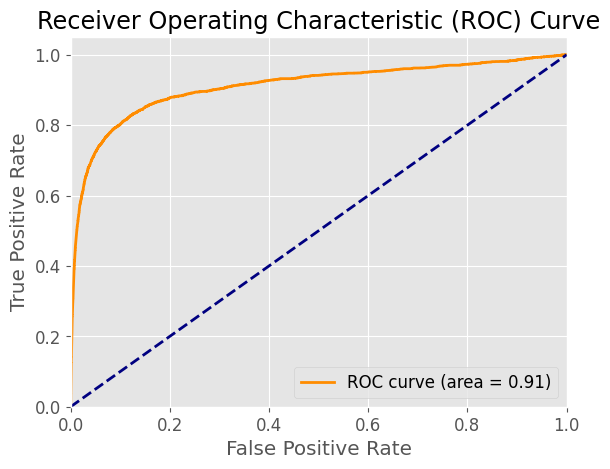

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, test_pred_weighted)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [16]:
index = pd.read_csv("./com/C_final.csv")["index"]

In [17]:
pd.DataFrame({'index':index,'predict':val_pred},index=index).to_csv("./C_final"+str(random.sample(range(1,1000000000),1)[0])+'.csv') 